# AI for Earth System Science Hackathon 2020
# HOLODEC Machine Learning Challenge Problem
Matt Hayman, Aaron Bansemer, David John Gagne, Gabrielle Gantos, Gunther Wallach, Natasha Flyer

## Introduction
![holodec probe on aircraft](holodec_images/image2.png)

The properties of the water and ice particles in clouds are critical to many aspects of weather and climate.  The size, shape, and concentration of ice particles control the radiative properties of cirrus clouds.  The spatial distribution of water droplets in warm clouds may influence the formation of drizzle and rain.  The interactions among droplets, ice particles, and aerosols impact precipitation, lightning, atmospheric chemistry, and more.  Measurements of natural cloud particles are often taken aboard research aircraft with instruments mounted on the wings.  One of the newer technologies used for these instruments is inline holographic imaging, which has the important advantage of being able to instantaneously record all of the particles inside a small volume of air.  Using this technology, the Holographic Detector for Clouds (HOLODEC) has been developed by the university community and NCAR to improve our cloud measurement capabilities.

A hologram captures electro-magnatic field amplitude and phase (or wavefront) incident on a detector.  In contrast, standard imaging captures only the amplitude of the electric field.  Unlike a standard image, holograms can be computationally refocused on any object within the capture volume using standard wave propagation calculations. The figure below shows an example of an inline hologram (large image) with five out of focus particles.  The five smaller images show the reconstruction from each particle by computationally propagating the electro-magnetic field back to the depth position of each particle. 

![holodec example images](holodec_images/image5.png)

HOLODEC is an airborne holographic cloud imager capable of capturing particle size distributions in a single shot, so a measured particle size distribution is localized to a specific part of the cloud (not accumulated over a long path length).  By capturing a hologram, each particle can be imaged irrespective of its location in the sample volume, and its size and position can be accurately captured.

While holographic imaging provides unparalleled information about cloud particles, processing the raw holograms is also computationally expensive.  Lacking prior knowledge of the particle position in depth, a typical HOLODEC hologram is reconstructed at 1000 planes (or depths) using standard diffraction calculations.  At each plane, a particle’s image sharpness is evaluated and the particle size and position is determined only at a plane where it is in focus.  In addition to the computational cost, the processing requires human intervention to recognize when a “particle” is really just artifacts of interfering scattered fields.

The objective of this project is to develop a machine learning solution to process HOLODEC data that is more computationally efficient than the first-principles based processor.  

An important factor in processing hologram data is that the scattered field from a particle spreads out as it propagates.  The image below shows the scattered field from a 50 µm particle at distances in increments of 0.1 mm from the particle (0 to 0.7 mm).  As the scattered field expands, it’s the power is also distributed over a larger area.

![holodec 3d](holodec_images/image1.png)

For simplicity, this project deals with simulated holographic data where particle shapes are limited to spheres.  Two datasets are provided.  The first dataset contains only one particle per hologram.  If you are successful in processing the first dataset, or you wish to immediately focus on a more challenging case, you can work on the second dataset that contains three particles per hologram.

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* s3fs




In [1]:
!pip install numpy scipy matplotlib xarray pandas scikit-learn tensorflow netcdf4 h5netcdf tqdm s3fs

In [3]:
import s3fs
import xarray as xr
fs = s3fs.S3FileSystem(anon=True)
bucket_files = fs.ls("ncar-aiml-data-commons")
print(bucket_files)
fobj = fs.open("ncar-aiml-data-commons/holodec/synthetic_holograms_1particle_training.nc")
ds = xr.open_dataset(fobj)
print(ds)

['ncar-aiml-data-commons/FY2020 NCAR Reinvestment Project Plan - DS-ML-CSAC.docx', 'ncar-aiml-data-commons/gecko', 'ncar-aiml-data-commons/goes', 'ncar-aiml-data-commons/holodec', 'ncar-aiml-data-commons/microphysics', 'ncar-aiml-data-commons/test.txt']
<xarray.Dataset>
Dimensions:  (hologram_number: 50000, particle: 50000, xsize: 600, ysize: 400)
Dimensions without coordinates: hologram_number, particle, xsize, ysize
Data variables:
    hid      (particle) float32 ...
    d        (particle) float32 ...
    x        (particle) float32 ...
    y        (particle) float32 ...
    z        (particle) float32 ...
    image    (hologram_number, xsize, ysize) uint8 ...
Attributes:
    DateCreated:           26-May-2020
    Nx:                    [600.]
    Ny:                    [400.]
    dx:                    [2.96e-06]
    dy:                    [2.96e-06]
    lambda:                [3.55e-07]
    Dpmin:                 [2.e-05]
    Dpmax:                 [7.e-05]
    zMin:             

In [4]:
image = ds["image"]

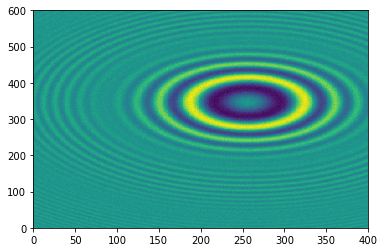

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.pcolormesh(image[4000])

## Data
The data summary should contain the following pieces of information:
* Data generation procedure (satellite, model, etc.) 
* Link to website containing more information about dataset
* Time span of the dataset
* Geographic coverage of the dataset
* Parameter space coverage (if synthetic)


The datasets consist of synthetically-generated holograms of cloud droplets.  Each dataset is in netCDF format, and contains a series of hologram images as well as the properties of each particle in the image.  The netCDF variable names and properties are as follows:

| Variable Name | Description | Dimensions | Units/Range|
| ------------- | :----:|:----------- |:------|
| image  | Stack of single-color images. Each image is 600x400 pixels, ranging from 0-255 in intensity. | nHolograms, 600, 400 | 0 to 255 (grayscale image) |
| x  |  X-position of each particle in the dataset.  The origin is at the center of the hologram image. | nParticles (can vary) | -888 to 888 micrometers |
| y  | Y-position of each particle in the dataset.  The origin is at the center of the hologram image. |  nParticles (can vary) | -592 to 592 micrometers |
| z  | Z-position of each particle in the dataset.  The origin is at the focal plane of the instrument (all particles are unfocused). | nParticles (can vary) | 14000 to 158000 micrometers |
| d  | Diameter of each simulated droplet | nParticles (can vary) | 20 to 70 micrometers |
| hid | Hologram ID specifies which hologram this particle is contained in.  For example, if hid=1, the corresponding x, y, z, and d variables are found in the first hologram. | nParticles (can vary) | 1 to nHolograms |
| Dx (global attribute) | Resolution of each pixel, == 2.96 micrometers.  Use if you wish to convert x/y position to pixel number |  |  |

There are two datasets for this project, a single-particle dataset and a multi-particle dataset.  The single-particle dataset only contains one particle per hologram (nHolograms = nParticles). There are 50,000 holograms in the training dataset that correspond to 50,000 particles.

The multi-particle dataset contains between one and three particles per hologram.  This dataset also contains 50,000 holograms, but approximately 100,000 particles.  Be sure to use the hid variable to figure out which hologram a particle is contained in.

The goal of this project is to be able to find particles in the holograms and determine their x, y, z, and d values.


![holodec 3d](holodec_images/image4.png)


### Potential Input Variables
| Variable Name | Units | Description | Relevance |
| ------------- | :----:|:----------- | :--------:|
| hologram   |  arbitrary |  8 bit (0-255) amplitude captured by CCD  | standard input data for processing  |



### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| x  |  µm     |  particle horizontal position |
| y  |  µm     |  particle vertical position  |
| z  | µm  | particle position in depth (along the direction of propagation) |
| d  | µm  | particle diameter |


### Training Set
The single-particle training dataset is in the netCDF format described above, with 50,000 holograms and 50,000 corresponding particles.

The multi-particle training dataset contains 50,000 holograms and 99,829 particles.

### Validation Set
The single-particle validation dataset is in the netCDF format described above, with 10,000 holograms and 10,000 corresponding particles.

The multi-particle validation dataset contains 10,000 holograms and 19,951 particles.


### Test Set
The single-particle test dataset is in the netCDF format described above, with 10,000 holograms and 10,000 corresponding particles.

The multi-particle test dataset contains 10,000 holograms and 19,914 particles.


### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

### Baseline Machine Learning Model
Description of DJ’s initial ConvNET architecture:
A baseline model for solving this problem uses a ConvNET architecture implemented in Keras.  The first two convolution layers consist of 5 x 5 pixel kernels with rectified linear unit (relu) activation followed by a 4 x 4 pixel max pool layer.  The first convolution layer has 8 channels and the second contains 16 channels.  The output of the second convolution layer is flattened and fed into a dense layer with 64 neurons and relu activation which then feeds into a second dense layer with 32 neurons and relu activation.  Finally the output layer consists of 4 neurons (for x, y, z and d outputs) and linear activation.  The model is trained using a mean absolute error (MAE) loss function

Mean absolute error in predictions:

| Variable Name | Error |
| ------------- |:----------- |
| x  |  30 µm     |
| y  |  26 µm     |
| z  |  55 µm     |
| d  |  45 µm     |

Training time: 20 epochs in 180 s

Description of baseline ML approach should include:
* Choice of ML software
* Type of ML model
* Hyperparameter choices and justification

## Metrics
An ideal solution to HOLODEC processing would leverage all the advantages of the instrument (unparalleled particle position and size accuracy) but reduce the drawbacks (processing time).  For this reason, the major components of the model assessment should include:
* MAE, and maximum error of each output (x, y, z, d)
* Processing time per hologram

Description of the different metrics used to assess performance on the challenge:
* Correctness Metric: how close are the predictions to the truth (e.g., RMSE or AUC) 
* Training time
* Inference time
* Model complexity
